<a href="https://colab.research.google.com/github/aaronsouza/ViT-DeHaze/blob/main/ViT_DeHaze1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from torch.nn.init import _calculate_fan_in_and_fan_out
from timm.models.layers import to_2tuple, trunc_normal_

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
class RLN(nn.Module):
	r"""Revised LayerNorm"""
	def __init__(self, dim, eps=1e-5, detach_grad=False):
		super(RLN, self).__init__()
		self.eps = eps
		self.detach_grad = detach_grad

		self.weight = nn.Parameter(torch.ones((1, dim, 1, 1)))
		self.bias = nn.Parameter(torch.zeros((1, dim, 1, 1)))

		self.meta1 = nn.Conv2d(1, dim, 1)
		self.meta2 = nn.Conv2d(1, dim, 1)

		trunc_normal_(self.meta1.weight, std=.02)
		nn.init.constant_(self.meta1.bias, 1)

		trunc_normal_(self.meta2.weight, std=.02)
		nn.init.constant_(self.meta2.bias, 0)

	def forward(self, input):
		mean = torch.mean(input, dim=(1, 2, 3), keepdim=True)
		std = torch.sqrt((input - mean).pow(2).mean(dim=(1, 2, 3), keepdim=True) + self.eps)

		normalized_input = (input - mean) / std

		if self.detach_grad:
			rescale, rebias = self.meta1(std.detach()), self.meta2(mean.detach())
		else:
			rescale, rebias = self.meta1(std), self.meta2(mean)

		out = normalized_input * self.weight + self.bias
		return out, rescale, rebias

In [ ]:
class Mlp(nn.Module):
	def __init__(self, network_depth, in_features, hidden_features=None, out_features=None):
		super().__init__()
		out_features = out_features or in_features
		hidden_features = hidden_features or in_features

		self.network_depth = network_depth

		self.mlp = nn.Sequential(
			nn.Conv2d(in_features, hidden_features, 1),
			nn.ReLU(True),
			nn.Conv2d(hidden_features, out_features, 1)
		)

		self.apply(self._init_weights)

	def _init_weights(self, m):
		if isinstance(m, nn.Conv2d):
			gain = (8 * self.network_depth) ** (-1/4)
			fan_in, fan_out = _calculate_fan_in_and_fan_out(m.weight)
			std = gain * math.sqrt(2.0 / float(fan_in + fan_out))
			trunc_normal_(m.weight, std=std)
			if m.bias is not None:
				nn.init.constant_(m.bias, 0)

	def forward(self, x):
		return self.mlp(x)

In [ ]:
def window_partition(x, window_size):
	B, H, W, C = x.shape
	x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
	windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size**2, C)
	return windows


def window_reverse(windows, window_size, H, W):
	B = int(windows.shape[0] / (H * W / window_size / window_size))
	x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
	x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
	return x


def get_relative_positions(window_size):
	coords_h = torch.arange(window_size)
	coords_w = torch.arange(window_size)

	coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
	coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
	relative_positions = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww

	relative_positions = relative_positions.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
	relative_positions_log  = torch.sign(relative_positions) * torch.log(1. + relative_positions.abs())

	return relative_positions_log

In [ ]:
class WindowAttention(nn.Module):
	def __init__(self, dim, window_size, num_heads):

		super().__init__()
		self.dim = dim
		self.window_size = window_size  # Wh, Ww
		self.num_heads = num_heads
		head_dim = dim // num_heads
		self.scale = head_dim ** -0.5

		relative_positions = get_relative_positions(self.window_size)
		self.register_buffer("relative_positions", relative_positions)
		self.meta = nn.Sequential(
			nn.Linear(2, 256, bias=True),
			nn.ReLU(True),
			nn.Linear(256, num_heads, bias=True)
		)

		self.softmax = nn.Softmax(dim=-1)

	def forward(self, qkv):
		B_, N, _ = qkv.shape

		qkv = qkv.reshape(B_, N, 3, self.num_heads, self.dim // self.num_heads).permute(2, 0, 3, 1, 4)

		q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

		q = q * self.scale
		attn = (q @ k.transpose(-2, -1))

		relative_position_bias = self.meta(self.relative_positions)
		relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
		attn = attn + relative_position_bias.unsqueeze(0)

		attn = self.softmax(attn)

		x = (attn @ v).transpose(1, 2).reshape(B_, N, self.dim)
		return x

In [ ]:
class Attention(nn.Module):
	def __init__(self, network_depth, dim, num_heads, window_size, shift_size, use_attn=False, conv_type=None):
		super().__init__()
		self.dim = dim
		self.head_dim = int(dim // num_heads)
		self.num_heads = num_heads

		self.window_size = window_size
		self.shift_size = shift_size

		self.network_depth = network_depth
		self.use_attn = use_attn
		self.conv_type = conv_type

		if self.conv_type == 'Conv':
			self.conv = nn.Sequential(
				nn.Conv2d(dim, dim, kernel_size=3, padding=1, padding_mode='reflect'),
				nn.ReLU(True),
				nn.Conv2d(dim, dim, kernel_size=3, padding=1, padding_mode='reflect')
			)

		if self.conv_type == 'DWConv':
			self.conv = nn.Conv2d(dim, dim, kernel_size=5, padding=2, groups=dim, padding_mode='reflect')

		if self.conv_type == 'DWConv' or self.use_attn:
			self.V = nn.Conv2d(dim, dim, 1)
			self.proj = nn.Conv2d(dim, dim, 1)

		if self.use_attn:
			self.QK = nn.Conv2d(dim, dim * 2, 1)
			self.attn = WindowAttention(dim, window_size, num_heads)

		self.apply(self._init_weights)

	def _init_weights(self, m):
		if isinstance(m, nn.Conv2d):
			w_shape = m.weight.shape

			if w_shape[0] == self.dim * 2:	# QK
				fan_in, fan_out = _calculate_fan_in_and_fan_out(m.weight)
				std = math.sqrt(2.0 / float(fan_in + fan_out))
				trunc_normal_(m.weight, std=std)
			else:
				gain = (8 * self.network_depth) ** (-1/4)
				fan_in, fan_out = _calculate_fan_in_and_fan_out(m.weight)
				std = gain * math.sqrt(2.0 / float(fan_in + fan_out))
				trunc_normal_(m.weight, std=std)

			if m.bias is not None:
				nn.init.constant_(m.bias, 0)

	def check_size(self, x, shift=False):
		_, _, h, w = x.size()
		mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
		mod_pad_w = (self.window_size - w % self.window_size) % self.window_size

		if shift:
			x = F.pad(x, (self.shift_size, (self.window_size-self.shift_size+mod_pad_w) % self.window_size,
						  self.shift_size, (self.window_size-self.shift_size+mod_pad_h) % self.window_size), mode='reflect')
		else:
			x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
		return x

	def forward(self, X):
		B, C, H, W = X.shape

		if self.conv_type == 'DWConv' or self.use_attn:
			V = self.V(X)

		if self.use_attn:
			QK = self.QK(X)
			QKV = torch.cat([QK, V], dim=1)

			# shift
			shifted_QKV = self.check_size(QKV, self.shift_size > 0)
			Ht, Wt = shifted_QKV.shape[2:]

			# partition windows
			shifted_QKV = shifted_QKV.permute(0, 2, 3, 1)
			qkv = window_partition(shifted_QKV, self.window_size)  # nW*B, window_size**2, C

			attn_windows = self.attn(qkv)

			# merge windows
			shifted_out = window_reverse(attn_windows, self.window_size, Ht, Wt)  # B H' W' C

			# reverse cyclic shift
			out = shifted_out[:, self.shift_size:(self.shift_size+H), self.shift_size:(self.shift_size+W), :]
			attn_out = out.permute(0, 3, 1, 2)

			if self.conv_type in ['Conv', 'DWConv']:
				conv_out = self.conv(V)
				out = self.proj(conv_out + attn_out)
			else:
				out = self.proj(attn_out)

		else:
			if self.conv_type == 'Conv':
				out = self.conv(X)				# no attention and use conv, no projection
			elif self.conv_type == 'DWConv':
				out = self.proj(self.conv(V))

		return out

In [ ]:
class TransformerBlock(nn.Module):
	def __init__(self, network_depth, dim, num_heads, mlp_ratio=4.,
				 norm_layer=nn.LayerNorm, mlp_norm=False,
				 window_size=8, shift_size=0, use_attn=True, conv_type=None):
		super().__init__()
		self.use_attn = use_attn
		self.mlp_norm = mlp_norm

		self.norm1 = norm_layer(dim) if use_attn else nn.Identity()
		self.attn = Attention(network_depth, dim, num_heads=num_heads, window_size=window_size,
							  shift_size=shift_size, use_attn=use_attn, conv_type=conv_type)

		self.norm2 = norm_layer(dim) if use_attn and mlp_norm else nn.Identity()
		self.mlp = Mlp(network_depth, dim, hidden_features=int(dim * mlp_ratio))

	def forward(self, x):
		identity = x
		if self.use_attn: x, rescale, rebias = self.norm1(x)
		x = self.attn(x)
		if self.use_attn: x = x * rescale + rebias
		x = identity + x

		identity = x
		if self.use_attn and self.mlp_norm: x, rescale, rebias = self.norm2(x)
		x = self.mlp(x)
		if self.use_attn and self.mlp_norm: x = x * rescale + rebias
		x = identity + x
		return x

In [ ]:
class BasicLayer(nn.Module):
	def __init__(self, network_depth, dim, depth, num_heads, mlp_ratio=4.,
				 norm_layer=nn.LayerNorm, window_size=8,
				 attn_ratio=0., attn_loc='last', conv_type=None):

		super().__init__()
		self.dim = dim
		self.depth = depth

		attn_depth = attn_ratio * depth

		if attn_loc == 'last':
			use_attns = [i >= depth-attn_depth for i in range(depth)]
		elif attn_loc == 'first':
			use_attns = [i < attn_depth for i in range(depth)]
		elif attn_loc == 'middle':
			use_attns = [i >= (depth-attn_depth)//2 and i < (depth+attn_depth)//2 for i in range(depth)]

		# build blocks
		self.blocks = nn.ModuleList([
			TransformerBlock(network_depth=network_depth,
							 dim=dim,
							 num_heads=num_heads,
							 mlp_ratio=mlp_ratio,
							 norm_layer=norm_layer,
							 window_size=window_size,
							 shift_size=0 if (i % 2 == 0) else window_size // 2,
							 use_attn=use_attns[i], conv_type=conv_type)
			for i in range(depth)])

	def forward(self, x):
		for blk in self.blocks:
			x = blk(x)
		return x

In [ ]:
class PatchEmbed(nn.Module):
	def __init__(self, patch_size=4, in_chans=3, embed_dim=96, kernel_size=None):
		super().__init__()
		self.in_chans = in_chans
		self.embed_dim = embed_dim

		if kernel_size is None:
			kernel_size = patch_size

		self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=kernel_size, stride=patch_size,
							  padding=(kernel_size-patch_size+1)//2, padding_mode='reflect')

	def forward(self, x):
		x = self.proj(x)
		return x


class PatchUnEmbed(nn.Module):
	def __init__(self, patch_size=4, out_chans=3, embed_dim=96, kernel_size=None):
		super().__init__()
		self.out_chans = out_chans
		self.embed_dim = embed_dim

		if kernel_size is None:
			kernel_size = 1

		self.proj = nn.Sequential(
			nn.Conv2d(embed_dim, out_chans*patch_size**2, kernel_size=kernel_size,
					  padding=kernel_size//2, padding_mode='reflect'),
			nn.PixelShuffle(patch_size)
		)

	def forward(self, x):
		x = self.proj(x)
		return x


class SKFusion(nn.Module):
	def __init__(self, dim, height=2, reduction=8):
		super(SKFusion, self).__init__()

		self.height = height
		d = max(int(dim/reduction), 4)

		self.avg_pool = nn.AdaptiveAvgPool2d(1)
		self.mlp = nn.Sequential(
			nn.Conv2d(dim, d, 1, bias=False),
			nn.ReLU(),
			nn.Conv2d(d, dim*height, 1, bias=False)
		)

		self.softmax = nn.Softmax(dim=1)

	def forward(self, in_feats):
		B, C, H, W = in_feats[0].shape

		in_feats = torch.cat(in_feats, dim=1)
		in_feats = in_feats.view(B, self.height, C, H, W)

		feats_sum = torch.sum(in_feats, dim=1)
		attn = self.mlp(self.avg_pool(feats_sum))
		attn = self.softmax(attn.view(B, self.height, C, 1, 1))

		out = torch.sum(in_feats*attn, dim=1)
		return out


In [ ]:
class DehazeFormer(nn.Module):
	def __init__(self, in_chans=3, out_chans=4, window_size=8,
				 embed_dims=[24, 48, 96, 48, 24],
				 mlp_ratios=[2., 4., 4., 2., 2.],
				 depths=[16, 16, 16, 8, 8],
				 num_heads=[2, 4, 6, 1, 1],
				 attn_ratio=[1/4, 1/2, 3/4, 0, 0],
				 conv_type=['DWConv', 'DWConv', 'DWConv', 'DWConv', 'DWConv'],
				 norm_layer=[RLN, RLN, RLN, RLN, RLN]):
		super(DehazeFormer, self).__init__()

		# setting
		self.patch_size = 4
		self.window_size = window_size
		self.mlp_ratios = mlp_ratios

		# split image into non-overlapping patches
		self.patch_embed = PatchEmbed(
			patch_size=1, in_chans=in_chans, embed_dim=embed_dims[0], kernel_size=3)

		# backbone
		self.layer1 = BasicLayer(network_depth=sum(depths), dim=embed_dims[0], depth=depths[0],
					   			 num_heads=num_heads[0], mlp_ratio=mlp_ratios[0],
					   			 norm_layer=norm_layer[0], window_size=window_size,
					   			 attn_ratio=attn_ratio[0], attn_loc='last', conv_type=conv_type[0])

		self.patch_merge1 = PatchEmbed(
			patch_size=2, in_chans=embed_dims[0], embed_dim=embed_dims[1])

		self.skip1 = nn.Conv2d(embed_dims[0], embed_dims[0], 1)

		self.layer2 = BasicLayer(network_depth=sum(depths), dim=embed_dims[1], depth=depths[1],
								 num_heads=num_heads[1], mlp_ratio=mlp_ratios[1],
								 norm_layer=norm_layer[1], window_size=window_size,
								 attn_ratio=attn_ratio[1], attn_loc='last', conv_type=conv_type[1])

		self.patch_merge2 = PatchEmbed(
			patch_size=2, in_chans=embed_dims[1], embed_dim=embed_dims[2])

		self.skip2 = nn.Conv2d(embed_dims[1], embed_dims[1], 1)

		self.layer3 = BasicLayer(network_depth=sum(depths), dim=embed_dims[2], depth=depths[2],
								 num_heads=num_heads[2], mlp_ratio=mlp_ratios[2],
								 norm_layer=norm_layer[2], window_size=window_size,
								 attn_ratio=attn_ratio[2], attn_loc='last', conv_type=conv_type[2])

		self.patch_split1 = PatchUnEmbed(
			patch_size=2, out_chans=embed_dims[3], embed_dim=embed_dims[2])

		assert embed_dims[1] == embed_dims[3]
		self.fusion1 = SKFusion(embed_dims[3])

		self.layer4 = BasicLayer(network_depth=sum(depths), dim=embed_dims[3], depth=depths[3],
								 num_heads=num_heads[3], mlp_ratio=mlp_ratios[3],
								 norm_layer=norm_layer[3], window_size=window_size,
								 attn_ratio=attn_ratio[3], attn_loc='last', conv_type=conv_type[3])

		self.patch_split2 = PatchUnEmbed(
			patch_size=2, out_chans=embed_dims[4], embed_dim=embed_dims[3])

		assert embed_dims[0] == embed_dims[4]
		self.fusion2 = SKFusion(embed_dims[4])

		self.layer5 = BasicLayer(network_depth=sum(depths), dim=embed_dims[4], depth=depths[4],
					   			 num_heads=num_heads[4], mlp_ratio=mlp_ratios[4],
					   			 norm_layer=norm_layer[4], window_size=window_size,
					   			 attn_ratio=attn_ratio[4], attn_loc='last', conv_type=conv_type[4])

		# merge non-overlapping patches into image
		self.patch_unembed = PatchUnEmbed(
			patch_size=1, out_chans=out_chans, embed_dim=embed_dims[4], kernel_size=3)


	def check_image_size(self, x):
		# NOTE: for I2I test
		_, _, h, w = x.size()
		mod_pad_h = (self.patch_size - h % self.patch_size) % self.patch_size
		mod_pad_w = (self.patch_size - w % self.patch_size) % self.patch_size
		x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
		return x

	def forward_features(self, x):
		x = self.patch_embed(x)
		x = self.layer1(x)
		skip1 = x

		x = self.patch_merge1(x)
		x = self.layer2(x)
		skip2 = x

		x = self.patch_merge2(x)
		x = self.layer3(x)
		x = self.patch_split1(x)

		x = self.fusion1([x, self.skip2(skip2)]) + x
		x = self.layer4(x)
		x = self.patch_split2(x)

		x = self.fusion2([x, self.skip1(skip1)]) + x
		x = self.layer5(x)
		x = self.patch_unembed(x)
		return x

	def forward(self, x):
		H, W = x.shape[2:]
		x = self.check_image_size(x)

		feat = self.forward_features(x)
		K, B = torch.split(feat, (1, 3), dim=1)

		x = K * x - B + x
		x = x[:, :, :H, :W]
		return x


def dehazeformer_t():
    return DehazeFormer(
		embed_dims=[24, 48, 96, 48, 24],
		mlp_ratios=[2., 4., 4., 2., 2.],
		depths=[4, 4, 4, 2, 2],
		num_heads=[2, 4, 6, 1, 1],
		attn_ratio=[0, 1/2, 1, 0, 0],
		conv_type=['DWConv', 'DWConv', 'DWConv', 'DWConv', 'DWConv'])


def dehazeformer_s():
    return DehazeFormer(
		embed_dims=[24, 48, 96, 48, 24],
		mlp_ratios=[2., 4., 4., 2., 2.],
		depths=[8, 8, 8, 4, 4],
		num_heads=[2, 4, 6, 1, 1],
		attn_ratio=[1/4, 1/2, 3/4, 0, 0],
		conv_type=['DWConv', 'DWConv', 'DWConv', 'DWConv', 'DWConv'])


def dehazeformer_b():
    return DehazeFormer(
        embed_dims=[24, 48, 96, 48, 24],
		mlp_ratios=[2., 4., 4., 2., 2.],
		depths=[16, 16, 16, 8, 8],
		num_heads=[2, 4, 6, 1, 1],
		attn_ratio=[1/4, 1/2, 3/4, 0, 0],
		conv_type=['DWConv', 'DWConv', 'DWConv', 'DWConv', 'DWConv'])


def dehazeformer_d():
    return DehazeFormer(
        embed_dims=[24, 48, 96, 48, 24],
		mlp_ratios=[2., 4., 4., 2., 2.],
		depths=[32, 32, 32, 16, 16],
		num_heads=[2, 4, 6, 1, 1],
		attn_ratio=[1/4, 1/2, 3/4, 0, 0],
		conv_type=['DWConv', 'DWConv', 'DWConv', 'DWConv', 'DWConv'])


def dehazeformer_w():
    return DehazeFormer(
        embed_dims=[48, 96, 192, 96, 48],
		mlp_ratios=[2., 4., 4., 2., 2.],
		depths=[16, 16, 16, 8, 8],
		num_heads=[2, 4, 6, 1, 1],
		attn_ratio=[1/4, 1/2, 3/4, 0, 0],
		conv_type=['DWConv', 'DWConv', 'DWConv', 'DWConv', 'DWConv'])


def dehazeformer_m():
    return DehazeFormer(
		embed_dims=[24, 48, 96, 48, 24],
		mlp_ratios=[2., 4., 4., 2., 2.],
		depths=[12, 12, 12, 6, 6],
		num_heads=[2, 4, 6, 1, 1],
		attn_ratio=[1/4, 1/2, 3/4, 0, 0],
		conv_type=['Conv', 'Conv', 'Conv', 'Conv', 'Conv'])


def dehazeformer_l():
    return DehazeFormer(
		embed_dims=[48, 96, 192, 96, 48],
		mlp_ratios=[2., 4., 4., 2., 2.],
		depths=[16, 16, 16, 12, 12],
		num_heads=[2, 4, 6, 1, 1],
		attn_ratio=[1/4, 1/2, 3/4, 0, 0],
		conv_type=['Conv', 'Conv', 'Conv', 'Conv', 'Conv'])

In [ ]:
import torch

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    return total_params, trainable_params, non_trainable_params

# Example usage with one of the DehazeFormer variants
model = dehazeformer_t()  # You can replace this with any variant (s, b, d, w, m, l)

total_params, trainable_params, non_trainable_params = count_parameters(model)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")
print(f"Trainable percentage: {100 * trainable_params / total_params:.2f}%")

Total parameters: 687,404
Trainable parameters: 687,404
Non-trainable parameters: 0
Trainable percentage: 100.00%


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
pip install kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/synthetic-objective-testing-set-sots-reside")

print("Path to dataset files:", path)

100%|██████████| 415M/415M [00:07<00:00, 55.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/balraj98/synthetic-objective-testing-set-sots-reside/versions/1


In [ ]:
# import os
# import torch
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt

# # 1. Verify the directory structure
# print("Contents of downloaded directory:")
# print(os.listdir(path))  # Should show ['indoor', 'outdoor'] or similar

# # 2. Define the dataset class
# class SOTSDataset(Dataset):
#     def __init__(self, root_dir, mode='indoor', transform=None):
#         """
#         Args:
#             root_dir: The path returned by kagglehub.dataset_download()
#             mode: 'indoor' or 'outdoor'
#             transform: Optional torchvision transforms
#         """
#         self.hazy_dir = os.path.join(root_dir, mode, 'hazy')
#         self.gt_dir = os.path.join(root_dir, mode, 'gt')
#         self.transform = transform

#         # Verify paths exist
#         if not os.path.exists(self.hazy_dir):
#             raise FileNotFoundError(f"Hazy images directory not found: {self.hazy_dir}")
#         if not os.path.exists(self.gt_dir):
#             raise FileNotFoundError(f"Ground truth directory not found: {self.gt_dir}")

#         self.image_pairs = self._load_pairs()

#     def _load_pairs(self):
#         """Match hazy images with their ground truth counterparts."""
#         pairs = []
#         for hazy_img in os.listdir(self.hazy_dir):
#             # SOTS naming convention: 'xxxx_hazy.png' pairs with 'xxxx.png'
#             gt_img = hazy_img.replace('_hazy', '')
#             gt_path = os.path.join(self.gt_dir, gt_img)
#             if os.path.exists(gt_path):
#                 pairs.append((hazy_img, gt_img))
#             else:
#                 print(f"Warning: No ground truth found for {hazy_img}")
#         return pairs

#     def __len__(self):
#         return len(self.image_pairs)

#     def __getitem__(self, idx):
#         hazy_img, gt_img = self.image_pairs[idx]

#         hazy_path = os.path.join(self.hazy_dir, hazy_img)
#         gt_path = os.path.join(self.gt_dir, gt_img)

#         # Load images
#         hazy = Image.open(hazy_path).convert('RGB')
#         gt = Image.open(gt_path).convert('RGB')

#         if self.transform:
#             hazy = self.transform(hazy)
#             gt = self.transform(gt)

#         return hazy, gt

# # 3. Define transforms
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),  # Resize to consistent dimensions
#     transforms.ToTensor(),          # Convert to tensor [0, 1]
#     # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Optional
# ])

# # 4. Create dataset and dataloader
# try:
#     dataset = SOTSDataset(root_dir=path, mode='indoor', transform=transform)
#     print(f"Successfully loaded dataset with {len(dataset)} pairs")

#     # Create dataloader
#     dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

#     # 5. Visualize a sample
#     def imshow(img, title=None):
#         """Helper to display a tensor image."""
#         plt.imshow(img.permute(1, 2, 0))  # CHW to HWC
#         if title:
#             plt.title(title)
#         plt.axis('off')

#     # Get a sample batch
#     hazy_batch, gt_batch = next(iter(dataloader))

#     # Plot first sample in batch
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     imshow(hazy_batch[0], "Hazy Image")
#     plt.subplot(1, 2, 2)
#     imshow(gt_batch[0], "Ground Truth")
#     plt.show()

# except Exception as e:
#     print(f"Error loading dataset: {e}")
#     print("Available directories:")
#     print(os.listdir(path))
#     print("Please verify the dataset structure matches expected format:")
#     print("SOTS/indoor/hazy/")
#     print("SOTS/indoor/gt/")

Contents of downloaded directory:
['outdoor', 'indoor', 'metadata_indoor.csv']
Successfully loaded dataset with 500 pairs


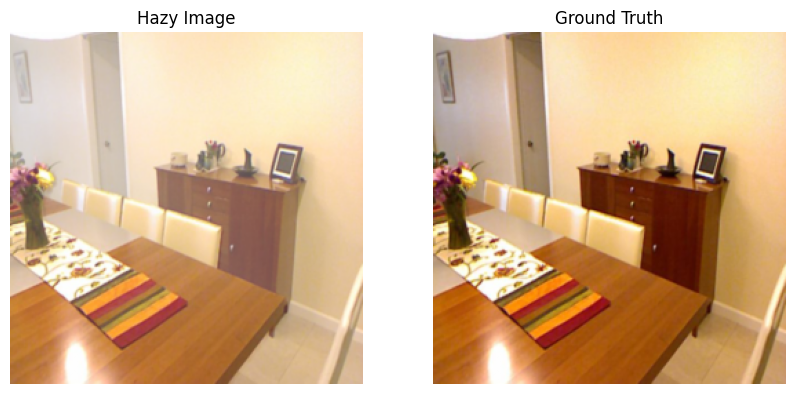

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the path to the dataset
#path = "path_to_SOTS_dataset"  # Replace with the actual path

# 1. Verify the directory structure
print("Contents of downloaded directory:")
print(os.listdir(path))  # Should show ['indoor', 'outdoor'] or similar

# 2. Define the dataset class
class SOTSDataset(Dataset):
    def __init__(self, root_dir, mode='indoor', transform=None):
        """
        Args:
            root_dir: The root directory containing 'indoor' and 'outdoor' folders.
            mode: 'indoor' or 'outdoor'.
            transform: Optional torchvision transforms.
        """
        self.clear_dir = os.path.join(root_dir, mode, 'clear')
        self.hazy_dir = os.path.join(root_dir, mode, 'hazy')
        self.transform = transform

        # Verify paths exist
        if not os.path.exists(self.clear_dir):
            raise FileNotFoundError(f"Clear images directory not found: {self.clear_dir}")
        if not os.path.exists(self.hazy_dir):
            raise FileNotFoundError(f"Hazy images directory not found: {self.hazy_dir}")

        self.image_pairs = self._load_pairs()

    def _load_pairs(self):
        """Match hazy images with their ground truth counterparts."""
        pairs = []
        for hazy_img in os.listdir(self.hazy_dir):
            # Extract the base filename to match with clear images
            base_name = hazy_img.split('_')[0]  # For outdoor, ignores coefficients
            gt_img = f"{base_name}.png" if hazy_img.endswith('.png') else f"{base_name}.jpg"
            gt_path = os.path.join(self.clear_dir, gt_img)
            if os.path.exists(gt_path):
                pairs.append((hazy_img, gt_img))
            else:
                print(f"Warning: No ground truth found for {hazy_img}")
        return pairs

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        hazy_img, gt_img = self.image_pairs[idx]

        hazy_path = os.path.join(self.hazy_dir, hazy_img)
        gt_path = os.path.join(self.clear_dir, gt_img)

        # Load images
        hazy = Image.open(hazy_path).convert('RGB')
        gt = Image.open(gt_path).convert('RGB')

        if self.transform:
            hazy = self.transform(hazy)
            gt = self.transform(gt)

        return hazy, gt

# 3. Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to consistent dimensions
    transforms.ToTensor(),          # Convert to tensor [0, 1]
])

# 4. Create dataset and dataloader
try:
    dataset = SOTSDataset(root_dir=path, mode='indoor', transform=transform)
    print(f"Successfully loaded dataset with {len(dataset)} pairs")

    # Create dataloader
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

    # 5. Visualize a sample
    def imshow(img, title=None):
        """Helper to display a tensor image."""
        plt.imshow(img.permute(1, 2, 0))  # CHW to HWC
        if title:
            plt.title(title)
        plt.axis('off')

    # Get a sample batch
    hazy_batch, gt_batch = next(iter(dataloader))

    # Plot first sample in batch
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(hazy_batch[0], "Hazy Image")
    plt.subplot(1, 2, 2)
    imshow(gt_batch[0], "Ground Truth")
    plt.show()

except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Available directories:")
    print(os.listdir(path))
    print("Please verify the dataset structure matches expected format:")
    print("SOTS/indoor/clear/")
    print("SOTS/indoor/hazy/")


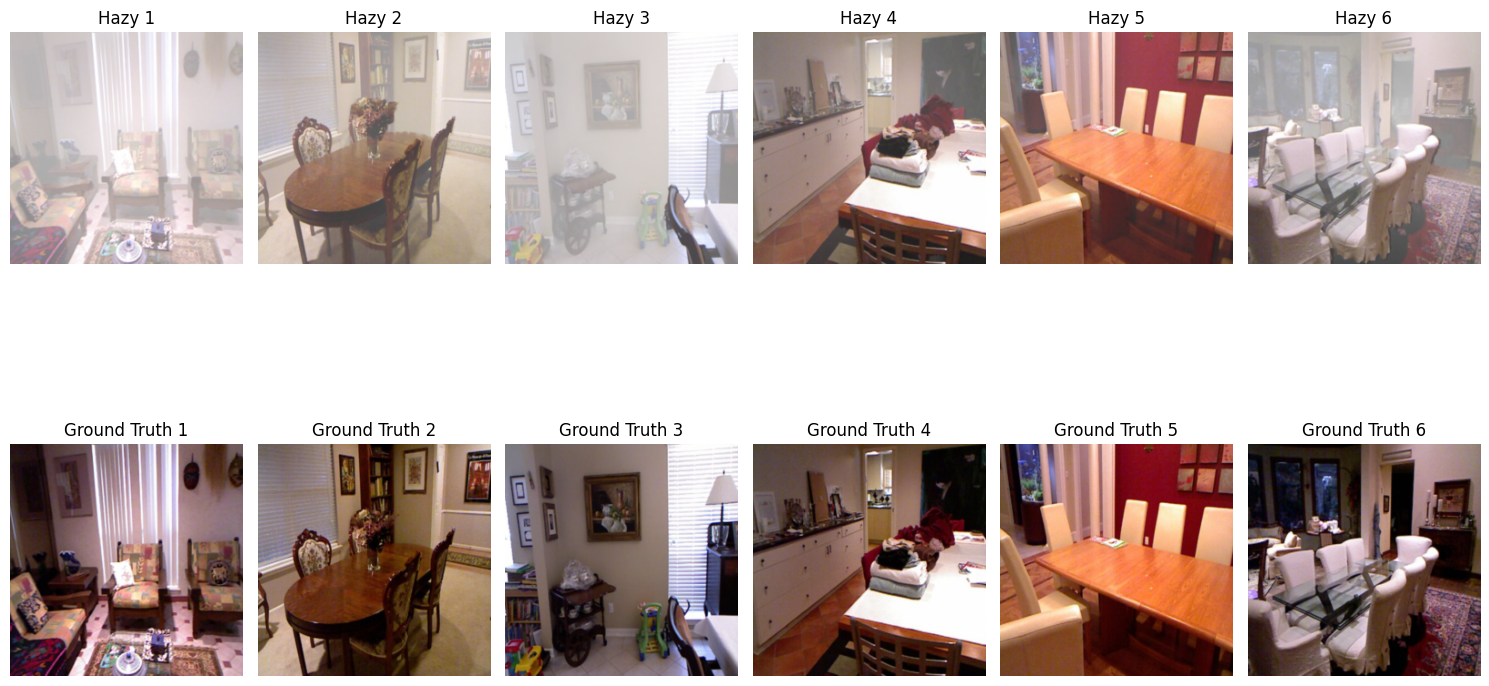

In [ ]:
# Visualize multiple samples from the dataset
try:
    # Get a sample batch
    hazy_batch, gt_batch = next(iter(dataloader))

    # Define the number of images to display
    num_images = min(len(hazy_batch), 6)  # Display up to 6 images from the batch

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Plot hazy image
        plt.subplot(2, num_images, i + 1)
        imshow(hazy_batch[i], f"Hazy {i+1}")

        # Plot corresponding ground truth image
        plt.subplot(2, num_images, i + 1 + num_images)
        imshow(gt_batch[i], f"Ground Truth {i+1}")

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error displaying images: {e}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import time
import os

# 1. Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 2. Initialize model
model = dehazeformer_t().to(device)

# 3. Loss function and optimizer
criterion = nn.L1Loss()  # Good for image-to-image tasks
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

Using device: cuda


In [ ]:
from datetime import datetime
import os
import time

# 3. Create experiment directory
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
exp_dir = f"experiments/{current_time}"
os.makedirs(f"{exp_dir}/checkpoints", exist_ok=True)
os.makedirs(f"{exp_dir}/samples", exist_ok=True)

# 4. Training parameters
num_epochs = 100
batch_size = 16
grad_accum_steps = 2  # For larger effective batch size

# 5. Training loop with validation
def train_epoch(model, loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    for i, (hazy, clean) in enumerate(loader):
        hazy = hazy.to(device)
        clean = clean.to(device)

        # Forward pass
        outputs = model(hazy)
        loss = criterion(outputs, clean) / grad_accum_steps

        # Backward pass
        loss.backward()

        # Gradient accumulation
        if (i + 1) % grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * grad_accum_steps

        # Save samples periodically
        if i % 50 == 0:
            save_image(torch.cat([hazy[0], outputs[0], clean[0]], dim=1),
                      f"{exp_dir}/samples/epoch_{epoch}_batch_{i}.png")

    return running_loss / len(loader)

def validate(model, loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for hazy, clean in loader:
            hazy = hazy.to(device)
            clean = clean.to(device)
            outputs = model(hazy)
            val_loss += criterion(outputs, clean).item()
    return val_loss / len(loader)


[TEST 1] Directory Structure
Directory structure is valid.
Contents of the directory: ['outdoor', 'indoor', 'metadata_indoor.csv']

[TEST 2] Dataset Loading
Dataset contains 500 image pairs.
Loaded sample pair shapes: Hazy: torch.Size([3, 256, 256]), GT: torch.Size([3, 256, 256])

[TEST 3] Image Transformations
Transformed image dimensions: torch.Size([3, 256, 256])
Image transformations are correct.

[TEST 4] DataLoader Functionality
Batch 1: Hazy batch shape: torch.Size([8, 3, 256, 256]), GT batch shape: torch.Size([8, 3, 256, 256])
Batch 2: Hazy batch shape: torch.Size([8, 3, 256, 256]), GT batch shape: torch.Size([8, 3, 256, 256])

[TEST 5] Visualization


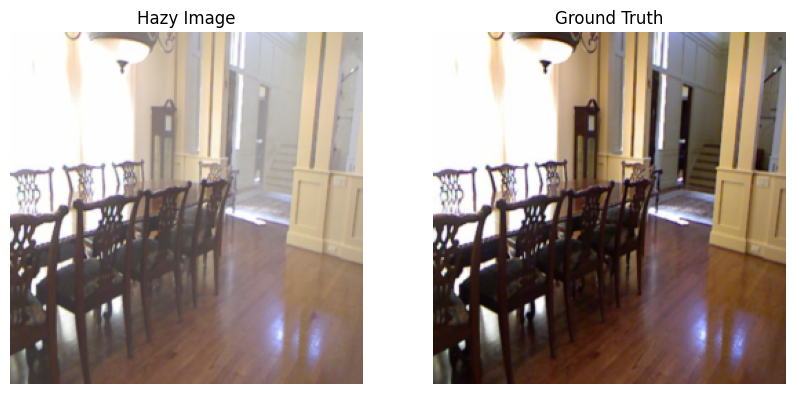


[TEST 6] Performance Test
Loaded all 500 image pairs in 23.00 seconds.

[TEST 7] Dataset Splitting
Train set size: 400, Test set size: 100
Dataset splitting is correct.


In [ ]:
import os
import time
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image

# Utility to display a tensor image
def imshow(tensor_img, title=None):
    plt.imshow(tensor_img.permute(1, 2, 0))  # Convert CHW to HWC
    if title:
        plt.title(title)
    plt.axis("off")

# Test 1: Verify Directory and File Structure
def test_directory_structure(path):
    try:
        assert os.path.exists(path), f"Root directory does not exist: {path}"
        print("Directory structure is valid.")
        print("Contents of the directory:", os.listdir(path))
    except AssertionError as e:
        print(e)

# Test 2: Dataset Loading Test
def test_dataset_loading(dataset):
    try:
        print(f"Dataset contains {len(dataset)} image pairs.")
        hazy, gt = dataset[0]  # Test the first pair
        print(f"Loaded sample pair shapes: Hazy: {hazy.shape}, GT: {gt.shape}")
    except Exception as e:
        print(f"Error in loading dataset: {e}")

# Test 3: Image Transformations
def test_image_transformations(dataset):
    try:
        hazy, gt = dataset[0]
        assert hazy.shape == gt.shape, "Transformed images should have the same shape."
        print(f"Transformed image dimensions: {hazy.shape}")
        assert hazy.max() <= 1.0 and hazy.min() >= 0.0, "Images are not normalized to [0, 1]."
        print("Image transformations are correct.")
    except AssertionError as e:
        print(e)

# Test 4: DataLoader Functionality
def test_dataloader(dataloader):
    try:
        for i, (hazy_batch, gt_batch) in enumerate(dataloader):
            print(f"Batch {i+1}: Hazy batch shape: {hazy_batch.shape}, GT batch shape: {gt_batch.shape}")
            if i == 1:  # Display two batches only
                break
    except Exception as e:
        print(f"Error in DataLoader: {e}")

# Test 5: Visualization
def test_visualization(dataset):
    try:
        hazy, gt = dataset[0]
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        imshow(hazy, title="Hazy Image")
        plt.subplot(1, 2, 2)
        imshow(gt, title="Ground Truth")
        plt.show()
    except Exception as e:
        print(f"Error in visualization: {e}")

# Test 6: Performance Test
def test_performance(dataset):
    try:
        start_time = time.time()
        for i in range(len(dataset)):
            _ = dataset[i]
        elapsed_time = time.time() - start_time
        print(f"Loaded all {len(dataset)} image pairs in {elapsed_time:.2f} seconds.")
    except Exception as e:
        print(f"Performance test failed: {e}")

# Test 7: Dataset Splitting
def test_dataset_split(dataset):
    from sklearn.model_selection import train_test_split
    try:
        indices = list(range(len(dataset)))
        train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
        train_set = [dataset[i] for i in train_indices]
        test_set = [dataset[i] for i in test_indices]
        print(f"Train set size: {len(train_set)}, Test set size: {len(test_set)}")
        assert len(set(train_indices).intersection(set(test_indices))) == 0, "Train and Test sets overlap."
        print("Dataset splitting is correct.")
    except Exception as e:
        print(f"Dataset splitting test failed: {e}")

# # Test 8: Error Handling
# def test_error_handling(path):
#     try:
#         _ = SOTSDataset(root_dir=path, mode='nonexistent')  # Non-existent mode
#     except FileNotFoundError as e:
#         print(f"Caught expected error: {e}")

# Main Test Suite
def run_tests(path):
    from torchvision import transforms

    # Define dataset and DataLoader
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        ToTensor(),
    ])

    try:
        dataset = SOTSDataset(root_dir=path, mode='indoor', transform=transform)
        dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

        # Run individual tests
        print("\n[TEST 1] Directory Structure")
        test_directory_structure(path)

        print("\n[TEST 2] Dataset Loading")
        test_dataset_loading(dataset)

        print("\n[TEST 3] Image Transformations")
        test_image_transformations(dataset)

        print("\n[TEST 4] DataLoader Functionality")
        test_dataloader(dataloader)

        print("\n[TEST 5] Visualization")
        test_visualization(dataset)

        print("\n[TEST 6] Performance Test")
        test_performance(dataset)

        print("\n[TEST 7] Dataset Splitting")
        test_dataset_split(dataset)

        # print("\n[TEST 8] Error Handling")
        # test_error_handling(path)

    except Exception as e:
        print(f"Test suite failed: {e}")

# Run all tests
path_to_dataset = path  # Update with your dataset path
run_tests(path_to_dataset)



Running Training Loop Test:


Epoch 1/1: 100%|██████████| 63/63 [00:28<00:00,  2.20it/s]

Epoch 1, Loss: 0.0369

Running Validation Dataset Test:
Training set size: 400, Validation set size: 100

Running Loss Function Test:


Loss value: 0.1784

Running Overfitting Test:
Epoch 1, Loss: 0.8498
Epoch 2, Loss: 0.6693
Epoch 3, Loss: 0.5048
Epoch 4, Loss: 0.3738
Epoch 5, Loss: 0.2691
Epoch 6, Loss: 0.1890
Epoch 7, Loss: 0.1373
Epoch 8, Loss: 0.1102
Epoch 9, Loss: 0.1130
Epoch 10, Loss: 0.1182
Overfitting test complete. Model should have very low loss on 2 samples.

Running Memory Consumption Test:
Memory used: -1667072 bytes

Running Data Augmentation Test:


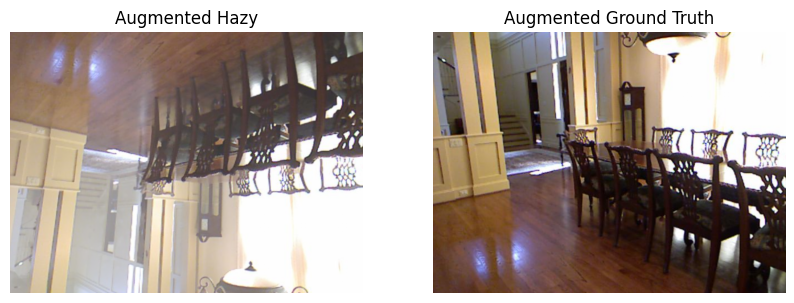

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import psutil


# Dataset Class
class SOTSDataset(Dataset):
    def __init__(self, root_dir, mode='indoor', transform=None):
        self.clear_dir = os.path.join(root_dir, mode, 'clear')
        self.hazy_dir = os.path.join(root_dir, mode, 'hazy')
        self.transform = transform

        if not os.path.exists(self.clear_dir):
            raise FileNotFoundError(f"Clear images directory not found: {self.clear_dir}")
        if not os.path.exists(self.hazy_dir):
            raise FileNotFoundError(f"Hazy images directory not found: {self.hazy_dir}")

        self.image_pairs = self._load_pairs()

    def _load_pairs(self):
        pairs = []
        for hazy_img in os.listdir(self.hazy_dir):
            base_name = hazy_img.split('_')[0]
            gt_img = f"{base_name}.png" if hazy_img.endswith('.png') else f"{base_name}.jpg"
            gt_path = os.path.join(self.clear_dir, gt_img)
            if os.path.exists(gt_path):
                pairs.append((hazy_img, gt_img))
        return pairs

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        hazy_img, gt_img = self.image_pairs[idx]
        hazy_path = os.path.join(self.hazy_dir, hazy_img)
        gt_path = os.path.join(self.clear_dir, gt_img)

        hazy = Image.open(hazy_path).convert('RGB')
        gt = Image.open(gt_path).convert('RGB')

        if self.transform:
            hazy = self.transform(hazy)
            gt = self.transform(gt)

        return hazy, gt


# Model Definition
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return x


# Helper Functions
def imshow(img, title=None):
    """Helper to display a tensor image."""
    plt.imshow(img.permute(1, 2, 0))
    if title:
        plt.title(title)
    plt.axis('off')


# Test Functions
def test_training_loop(dataloader, epochs=1):
    model = SimpleCNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for hazy, gt in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            outputs = model(hazy)
            loss = criterion(outputs, gt)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader):.4f}")


def test_validation_dataset(dataset):
    indices = list(range(len(dataset)))
    train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

    train_set = torch.utils.data.Subset(dataset, train_indices)
    val_set = torch.utils.data.Subset(dataset, val_indices)

    print(f"Training set size: {len(train_set)}, Validation set size: {len(val_set)}")
    return train_set, val_set


def test_loss_function(dataloader):
    model = SimpleCNN()
    criterion = nn.MSELoss()

    hazy, gt = next(iter(dataloader))
    outputs = model(hazy)
    loss = criterion(outputs, gt)

    print(f"Loss value: {loss.item():.4f}")


def test_overfitting(dataset, epochs=100):
    small_dataset = torch.utils.data.Subset(dataset, range(2))
    dataloader = DataLoader(small_dataset, batch_size=1, shuffle=True)

    model = SimpleCNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for hazy, gt in dataloader:
            optimizer.zero_grad()
            outputs = model(hazy)
            loss = criterion(outputs, gt)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

    print("Overfitting test complete. Model should have very low loss on 2 samples.")


def test_memory_consumption(dataloader):
    initial_memory = psutil.virtual_memory().used
    for hazy, gt in dataloader:
        pass
    final_memory = psutil.virtual_memory().used

    print(f"Memory used: {final_memory - initial_memory} bytes")


def test_data_augmentation(dataset):
    from torchvision.transforms import Compose, RandomHorizontalFlip, RandomVerticalFlip

    transform = Compose([
        RandomHorizontalFlip(p=0.5),
        RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
    ])

    dataset.transform = transform

    hazy, gt = dataset[0]
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(hazy, "Augmented Hazy")
    plt.subplot(1, 2, 2)
    imshow(gt, "Augmented Ground Truth")
    plt.show()


# Main Code Execution
if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    try:
        dataset = SOTSDataset(root_dir=path, mode='indoor', transform=transform)
        dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

        # Call Tests
        print("\nRunning Training Loop Test:")
        test_training_loop(dataloader, epochs=1)

        print("\nRunning Validation Dataset Test:")
        train_set, val_set = test_validation_dataset(dataset)

        print("\nRunning Loss Function Test:")
        test_loss_function(dataloader)

        print("\nRunning Overfitting Test:")
        test_overfitting(dataset, epochs=10)

        print("\nRunning Memory Consumption Test:")
        test_memory_consumption(dataloader)

        print("\nRunning Data Augmentation Test:")
        test_data_augmentation(dataset)

    except Exception as e:
        print(f"Error: {e}")


Average PSNR: 8.60, Average SSIM: 0.1905
Total Inference Time: 30.17 seconds


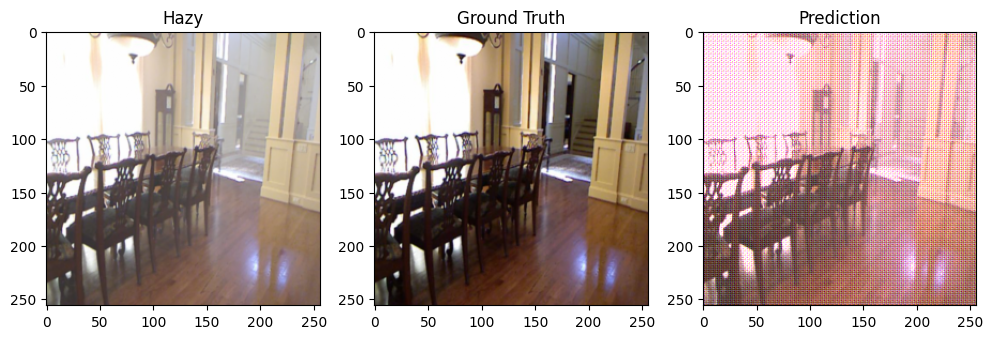

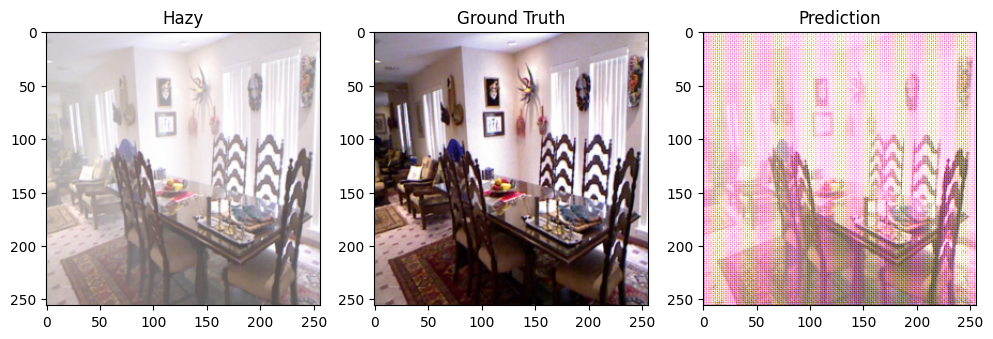

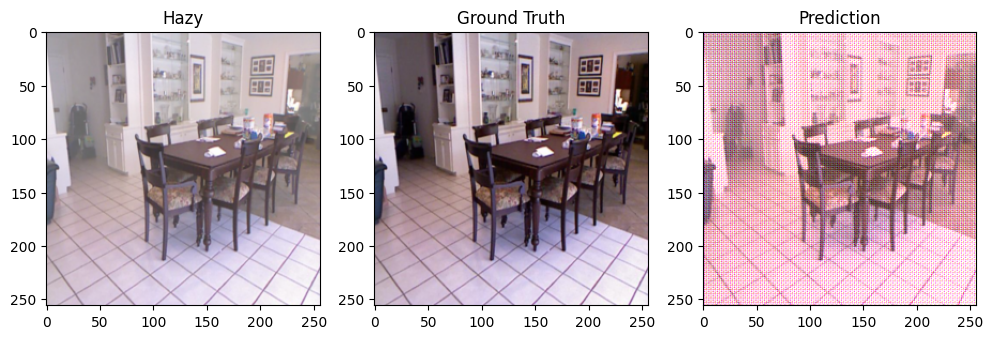

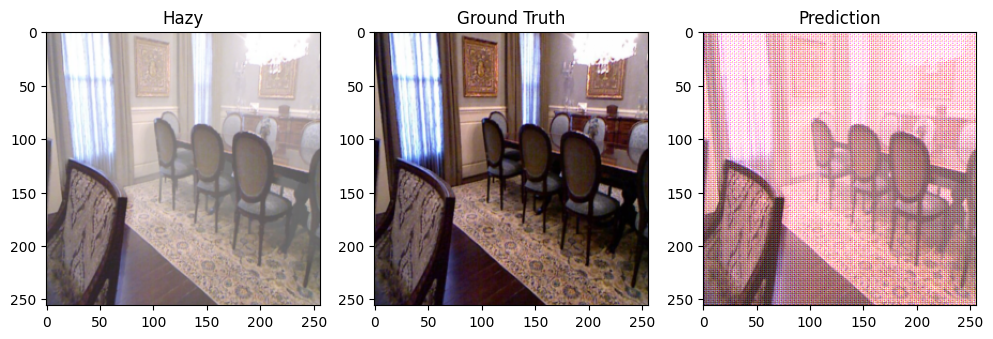

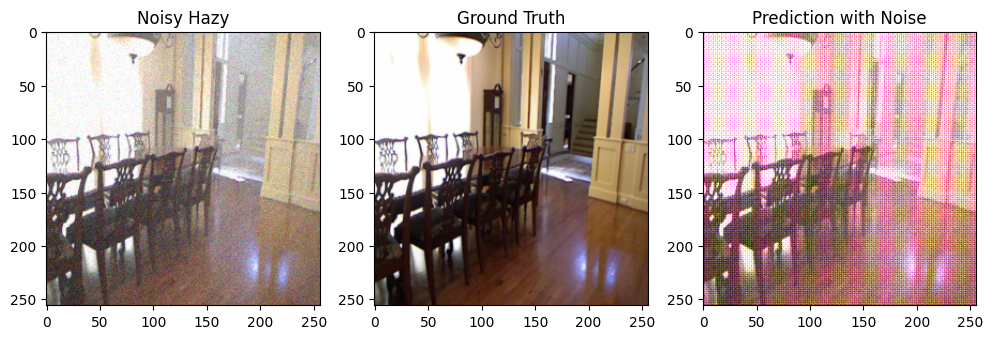

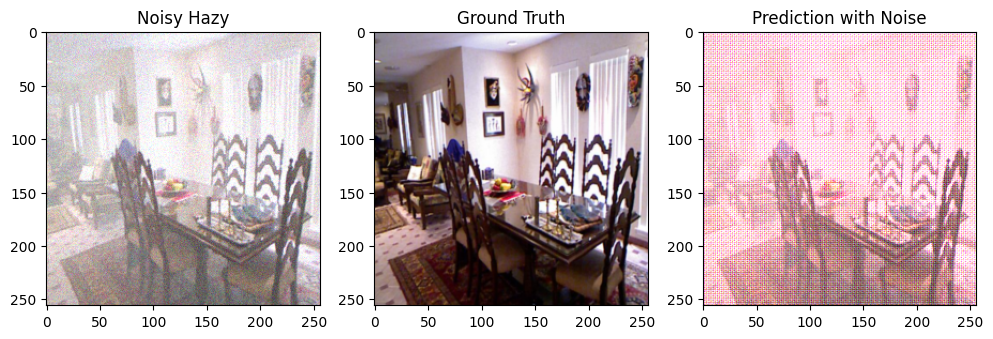

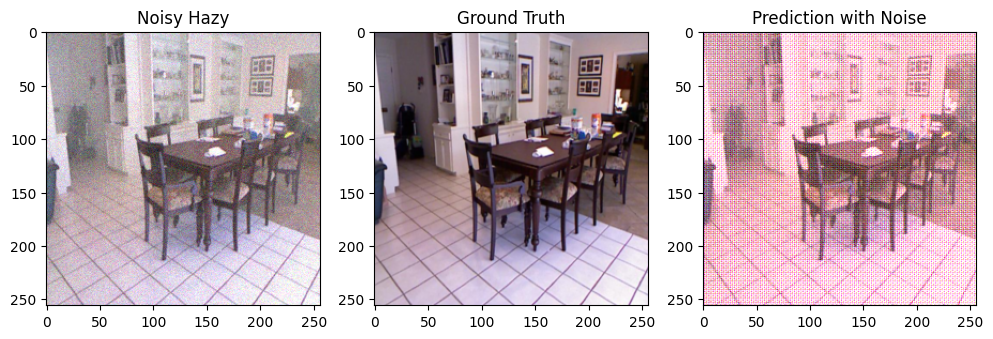

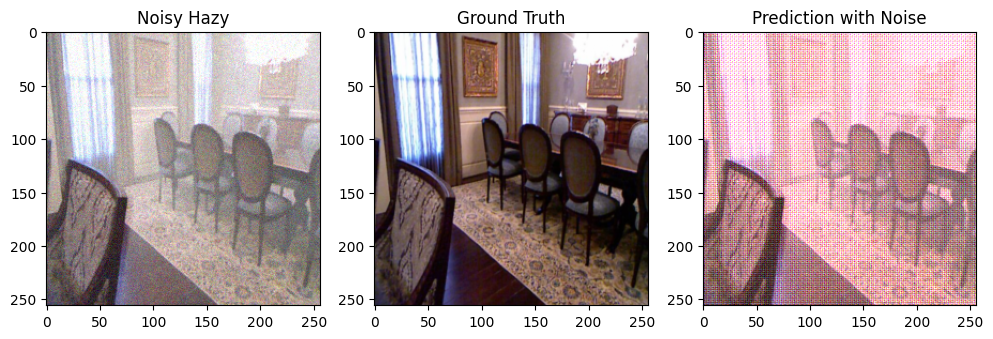

In [ ]:
import os
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import matplotlib.pyplot as plt

# 1. Dataset Definition
class SOTSDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, mode='indoor', transform=None):
        self.clear_dir = os.path.join(root_dir, mode, 'clear')
        self.hazy_dir = os.path.join(root_dir, mode, 'hazy')
        self.transform = transform
        self.image_pairs = self._load_pairs()

    def _load_pairs(self):
        pairs = []
        for hazy_img in os.listdir(self.hazy_dir):
            base_name = hazy_img.split('_')[0]
            gt_img = f"{base_name}.png" if hazy_img.endswith('.png') else f"{base_name}.jpg"
            gt_path = os.path.join(self.clear_dir, gt_img)
            if os.path.exists(gt_path):
                pairs.append((hazy_img, gt_img))
        return pairs

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        hazy_img, gt_img = self.image_pairs[idx]
        hazy_path = os.path.join(self.hazy_dir, hazy_img)
        gt_path = os.path.join(self.clear_dir, gt_img)
        hazy = Image.open(hazy_path).convert('RGB')
        gt = Image.open(gt_path).convert('RGB')
        if self.transform:
            hazy = self.transform(hazy)
            gt = self.transform(gt)
        return hazy, gt

# 2. Transforms and DataLoader
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
dataset = SOTSDataset(root_dir=path, mode="indoor", transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

# # 3. Model Loading (Assuming the model is pre-trained and saved)
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = torch.load("path_to_saved_model.pth", map_location=device)
# model.eval()

# 4. Evaluation Metrics
def compute_metrics(pred, gt):
    pred_np = pred.permute(1, 2, 0).cpu().numpy()  # CHW to HWC
    gt_np = gt.permute(1, 2, 0).cpu().numpy()
    pred_np = np.clip(pred_np, 0, 1)  # Ensure values are within [0, 1]
    gt_np = np.clip(gt_np, 0, 1)      # Ensure values are within [0, 1]

    win_size = min(7, pred_np.shape[0], pred_np.shape[1])  # Ensure win_size fits
    data_range = 1.0  # Pixel values are normalized to [0, 1]

    psnr_val = psnr(gt_np, pred_np, data_range=data_range)  # Pass data_range to PSNR
    ssim_val = ssim(gt_np, pred_np, win_size=win_size, channel_axis=2, data_range=data_range)  # Pass data_range to SSIM
    return psnr_val, ssim_val



# 5. Run Evaluations
results = []
start_time = time.time()
for i, (hazy, gt) in enumerate(dataloader):
    hazy, gt = hazy.to(device), gt.to(device)
    with torch.no_grad():
        pred = model(hazy)
    for j in range(hazy.size(0)):
        psnr_val, ssim_val = compute_metrics(pred[j], gt[j])
        results.append((psnr_val, ssim_val))
    # Save visualizations
    save_image(pred, f"output_batch_{i}.png")
end_time = time.time()

# Print Average Metrics
avg_psnr = np.mean([x[0] for x in results])
avg_ssim = np.mean([x[1] for x in results])
print(f"Average PSNR: {avg_psnr:.2f}, Average SSIM: {avg_ssim:.4f}")
print(f"Total Inference Time: {end_time - start_time:.2f} seconds")

# 6. Qualitative Visualization
hazy_sample, gt_sample = next(iter(dataloader))
with torch.no_grad():
    pred_sample = model(hazy_sample.to(device))
for i in range(4):  # Display 4 images
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(hazy_sample[i].permute(1, 2, 0).cpu().numpy())
    plt.title("Hazy")
    plt.subplot(1, 3, 2)
    plt.imshow(gt_sample[i].permute(1, 2, 0).cpu().numpy())
    plt.title("Ground Truth")
    plt.subplot(1, 3, 3)
    plt.imshow(pred_sample[i].permute(1, 2, 0).cpu().numpy())
    plt.title("Prediction")
    plt.show()

# 7. Ablation Study Placeholder (Modify model and retrain for this)
# Example: Disable attention layers, or change loss function to L1
# Measure performance again and compare results.

# 8. Robustness Testing (Example: Add Gaussian noise)
def add_noise(img, std=0.05):
    noise = torch.randn_like(img) * std
    return torch.clamp(img + noise, 0, 1)

# Apply noise to hazy images and evaluate
noisy_hazy = add_noise(hazy_sample)
with torch.no_grad():
    noisy_pred = model(noisy_hazy.to(device))
for i in range(4):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(noisy_hazy[i].permute(1, 2, 0).cpu().numpy())
    plt.title("Noisy Hazy")
    plt.subplot(1, 3, 2)
    plt.imshow(gt_sample[i].permute(1, 2, 0).cpu().numpy())
    plt.title("Ground Truth")
    plt.subplot(1, 3, 3)
    plt.imshow(noisy_pred[i].permute(1, 2, 0).cpu().numpy())
    plt.title("Prediction with Noise")
    plt.show()
